## Generalized tensors for solving OT problems

Hi. The Multimarginal Optimal Transport problem can be solved via the Sinkhorn algorithm, or simple backpropagation, if we parameterize the Kantorovich potentials of the dual problem with the neural network. Gradient ascent/descent also emerges in Sinkhorn if we use non-Shannon entropy as a regularizer.

In any case, computationally we are bounded to use multidimensional arrays (Numpy) or autograd tensors (pytorch, tensorflow, jax, etc.) to represent parts of the problem, i.e. the optimal plan $P$, cost tensor $C$, entropy $H$, Kantorovich potentials $\{f_i\}$. 

Here I use a simple wrapper that makes any piecewise-differentiable function behave like a tensor. Basically, every tensor is just a function of its indices, so I tried to implement this behavior in pytorch.

### First, let's create a gaussian tensor and plot its histogram

Please mind how we approximate it to get an ordinary tensor from the generalized one

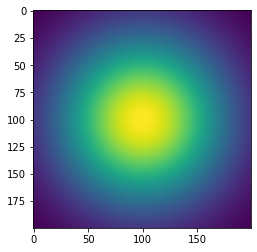

In [1]:
from funtensors import FT, Gaussian, Uniform
import matplotlib.pyplot as plt

g = Gaussian([0., 0.], [[.3, 0.], [0., .3]])

plt.imshow(g.histapprox[-1:1:0.01, -1:1:0.01])

## Here let's try to sum two Gaussians

The summation works the same way as for the ordinary tensors

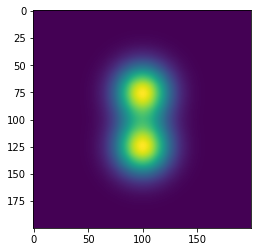

In [2]:
g1 = Gaussian([-0.25, 0.], [[.03, 0.], [0., .03]])
g2 = Gaussian([0.25, 0.], [[.03, 0.], [0., .03]])

g = (g1._ij + g2._ij)

plt.imshow(g.histapprox[-1:1:0.01, -1:1:0.01])

## Let's try to convolve a gaussian with the uniform

The wrapper has intuitively simple convolution interface, you set indices to your tensors, multiply them, and then run the convolution function (here we use the simple histogram integration, while it is basically possible to use any integration method)

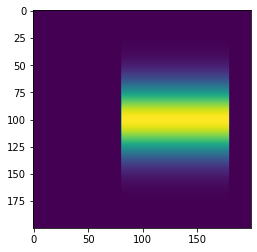

In [3]:
g1 = Gaussian([0, 0], [[.05, 0.], [0., .05]])
g2 = Uniform([-0.2, -0.2], [0.8, 0.8])

g = g1._ij * g2._jk

plt.imshow((g.boxconv(-1, 1, 100)).histapprox[-1:1:0.01, -1:1:0.01])

In [11]:
# Backpropagating directly through the dual problem
# (The Sinkhorn Step is to be implemented the same way)

from xml.dom import xmlbuilder
import torch
from itertools import combinations
from functools import lru_cache

class CoulombCost(torch.nn.Module):
    def __init__(self):
        super(CoulombCost, self).__init__()

    def forward(self, x):
        s = list(range(x.shape[1]))
        a = torch.cat(tuple(torch.unsqueeze(x[:, c[0]] - x[:, c[1]], -1) for c in list(combinations(s, 2))), 1)
        return 1/(torch.abs(torch.sum(a,1))+1)

class ShannonEntropy(torch.nn.Module):
    def __init__(self):
        super(ShannonEntropy, self).__init__()

    def forward(self, x):
        return x**2 / 2

class KantorovichPotentials(torch.nn.Module):
    def __init__(self, marginals, width):
        super(KantorovichPotentials, self).__init__()
        #self.register_parameter("param", torch.nn.Parameter(torch.randn(marginals, width, requires_grad=True)))
        self.width = width
        self.marginals = marginals
        self.support = torch.arange(0, width)
        self.nn1 = torch.nn.Linear(2, 100)
        self.nn2 = torch.nn.Linear(100, 1)

    def soft_one_hot(self, t, w):
        a = torch.arange(0, w)
        return torch.nn.ReLU()(a-(t-1)) * torch.nn.ReLU()((t+1) - a)

    def forward(self, x):
        left_hot = self.soft_one_hot(x[:, 0, None], self.marginals)[:]
        right_hot = self.soft_one_hot(x[:, 1, None], self.width)[:].T
        #return torch.diag(left_hot @ self.param @ right_hot)
        return torch.squeeze(self.nn2(self.nn1(x)))
    
class Marginals(torch.nn.Module):
    def __init__(self, marginals, width):
        super(Marginals, self).__init__()
        self.width = width
        self.support = torch.arange(0, width)
        self.nn1 = torch.nn.Linear(3, 100)
        self.nn2 = torch.nn.Linear(100, 1)

    def forward(self, x):
        return torch.squeeze(self.nn2(self.nn1(x)))

MARGINALS = 3
WIDTH = 10
EPSILON = 0.1

C = FT.from_torch_module(CoulombCost())
H = FT.from_torch_module(ShannonEntropy())
f = FT.from_torch_module(KantorovichPotentials(
    marginals = MARGINALS,
    width = WIDTH
))
m = FT.from_torch_module(Marginals(
    marginals = MARGINALS,
    width = WIDTH
))

optimizer = torch.optim.Adam(f.parameters())

# solve by simple gradient descent

for epoch in range(10):
    l_marginals = (f.train.to_tensor_sum(0, 3, 'ijk') * m.infer._ijk).bc(-10, 10, 10)
    l_entropy = EPSILON * H.comp(
        (
            f.train.to_tensor_sum(0, 3, 'ijk') - C._ijk
        ) / EPSILON
    )._IJK.bc(-10, 10, 10)
    L = l_marginals + l_entropy
    optimizer.zero_grad()
    L.scalar.backward()
    print(L.scalar.item())
    optimizer.step()

68082.4140625
50639.98828125
37433.6484375
26652.251953125
17709.09375
10869.0029296875
6360.48974609375
3871.44921875
2779.29443359375
2694.600830078125
